<a href="https://colab.research.google.com/github/JannatunNayeem-meem/Ekjam/blob/main/AI_Lab_05a_Pretrained_CNN(Edited).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("rifat963/pumpkin")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/rifat963/pumpkin/versions/2


In [15]:
import shutil

src = '/root/.cache/kagglehub/datasets/rifat963/pumpkin/versions/2'
dst = '/content'

shutil.copytree(src, dst, dirs_exist_ok=True)

'/content'

In [16]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models


from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
import numpy as np
import matplotlib.pyplot as plt
import itertools


In [17]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])): # itertools is now accessible
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [18]:
# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


# Data transforms for training and validation

In [19]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ]),
}

In [20]:
data_dir = '/content/Augmented/Augmented'  # Update this with your local path
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=32,
                                              shuffle=True, num_workers=4)
               for x in ['train', 'val']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [22]:
# List of pretrained models to experiment with
pretrained_models = {
    'resnet18': models.resnet18(pretrained=True),
    #'resnet50': models.resnet50(pretrained=True),
    #'efficientnet_b0': models.efficientnet_b0(pretrained=True)
}

In [23]:
num_classes = len(class_names)
print(f"Number of classes:{num_classes}")
num_epochs = 2  # Adjust as needed

Number of classes:5


In [24]:
def train_and_evaluate_model(model, model_name):
    # Modify final layer according to the architecture
    if model_name.startswith('resnet'):
        num_ftrs = model.fc.in_features
        model.fc = nn.Linear(num_ftrs, num_classes)
    elif 'efficientnet' in model_name:
        num_ftrs = model.classifier[1].in_features
        model.classifier[1] = nn.Linear(num_ftrs, num_classes)

    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

    print(f"\nTraining model: {model_name}")

    # Training loop
    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    _, preds = torch.max(outputs, 1)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            print(f"{phase.capitalize()} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

    # After training, evaluate on the validation set:
    model.eval()
    all_labels = []
    all_preds = []
    all_probs = []  # to store probabilities for ROC curve

    with torch.no_grad():
        for inputs, labels in dataloaders['val']:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            probabilities = torch.softmax(outputs, dim=1)
            _, preds = torch.max(outputs, 1)

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            all_probs.extend(probabilities.cpu().numpy())

    all_labels = np.array(all_labels)
    all_preds = np.array(all_preds)
    all_probs = np.array(all_probs)

    # Classification report and confusion matrix
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=class_names))

    print("Confusion Matrix:")
    cm = confusion_matrix(all_labels, all_preds) # Assign the confusion matrix to cm
    #print(cm)

    plot_confusion_matrix(cm, classes=class_names, title=f'Confusion Matrix for {model_name}')
    # ROC curve for each class (One-vs-Rest)
    fpr = {}
    tpr = {}
    roc_auc = {}
    # Binarize the output labels for multi-class ROC computation
    labels_binarized = label_binarize(all_labels, classes=range(num_classes))

    plt.figure()
    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(labels_binarized[:, i], all_probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        plt.plot(fpr[i], tpr[i],
                 label=f'ROC curve for {class_names[i]} (area = {roc_auc[i]:0.2f})')

    plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line for random chance
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curves for {model_name}')
    plt.legend(loc="lower right")
    plt.show()


Training model: resnet18
Epoch 1/2
Train Loss: 0.7872 Acc: 0.7052
Val Loss: 0.5384 Acc: 0.8195
Epoch 2/2
Train Loss: 0.4667 Acc: 0.8302
Val Loss: 0.5152 Acc: 0.8195

Classification Report:
                     precision    recall  f1-score   support

Bacterial Leaf Spot       0.81      0.68      0.74        76
       Downy Mildew       0.75      0.92      0.83        79
       Healthy Leaf       0.80      0.94      0.86        80
     Mosaic Disease       0.92      0.93      0.92        72
     Powdery_Mildew       0.85      0.65      0.74        92

           accuracy                           0.82       399
          macro avg       0.83      0.83      0.82       399
       weighted avg       0.82      0.82      0.82       399

Confusion Matrix:
Confusion matrix, without normalization
[[52  6 14  0  4]
 [ 0 73  0  1  5]
 [ 5  0 75  0  0]
 [ 0  3  0 67  2]
 [ 7 15  5  5 60]]


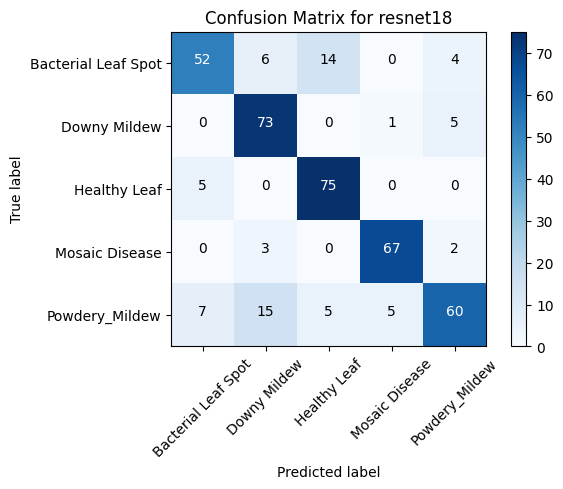

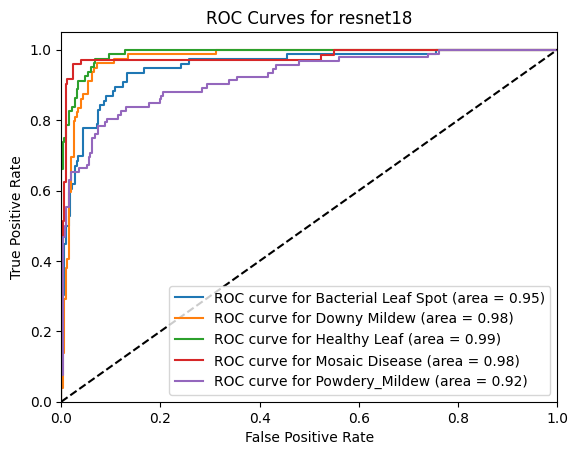

In [25]:
# Loop through each pretrained model, train and evaluate
for name, model in pretrained_models.items():
    train_and_evaluate_model(model, name)

In [59]:
from torchvision import models

# List of pretrained models to experiment with
pretrained_models = {
    'densenet161': models.densenet161(pretrained=True),
    'inception_v3': models.inception_v3(pretrained=True),
    'mobilenet_v3_small': models.mobilenet_v3_small(pretrained=True)

}


In [65]:
num_classes = len(class_names)
print(f"Number of classes: {num_classes}")

# Optimal number of epochs for each model to achieve higher accuracy
optimal_epochs = {
    'densenet161': 5,
    'inception_v3': 5,
    'mobilenet_v3_small': 5
}

print(f"Optimal epochs for each model: {optimal_epochs}")

Number of classes: 5
Optimal epochs for each model: {'densenet161': 5, 'inception_v3': 5, 'mobilenet_v3_small': 5}


In [68]:
def train_and_evaluate_model(model, model_name):
    # Modify final layer according to the architecture
    if model_name.startswith('resnet'):
        num_ftrs = model.fc.in_features
        model.fc = nn.Linear(num_ftrs, num_classes)
    elif model_name.startswith('densenet'):
        num_ftrs = model.classifier.in_features
        model.classifier = nn.Linear(num_ftrs, num_classes)
    elif model_name.startswith('inception'):
        num_ftrs = model.fc.in_features
        model.fc = nn.Linear(num_ftrs, num_classes)
    elif model_name.startswith('mobilenet'):
        num_ftrs = model.classifier[-1].in_features
        model.classifier[-1] = nn.Linear(num_ftrs, num_classes)

    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

    # Training loop
    for epoch in range(num_epochs):
        print(f"Epoch {epoch + 1}/{num_epochs}")
        for phase in ['train', 'val']:
            model.train() if phase == 'train' else model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    _, preds = torch.max(outputs, 1)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            print(f"{phase.capitalize()} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

    # Evaluation on the validation set
    model.eval()
    all_labels, all_preds, all_probs = [], [], []

    with torch.no_grad():
        for inputs, labels in dataloaders['val']:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            probabilities = torch.softmax(outputs, dim=1)
            _, preds = torch.max(outputs, 1)

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            all_probs.extend(probabilities.cpu().numpy())

    all_labels = np.array(all_labels)
    all_preds = np.array(all_preds)
    all_probs = np.array(all_probs)

    # Classification report and confusion matrix
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=class_names))

    cm = confusion_matrix(all_labels, all_preds)
    plot_confusion_matrix(cm, classes=class_names, title=f'Confusion Matrix for {model_name}')

    # ROC curves
    labels_binarized = label_binarize(all_labels, classes=range(num_classes))
    plt.figure()
    for i in range(num_classes):
        fpr, tpr, _ = roc_curve(labels_binarized[:, i], all_probs[:, i])
        plt.plot(fpr, tpr, label=f'Class {class_names[i]}')

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curves for {model_name}')
    plt.legend(loc="lower right")
    plt.show()


In [71]:

def evaluate_model_performance(model, dataloader, device):
    model.eval()  # Set to evaluation mode
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            correct += torch.sum(preds == labels.data).item()
            total += labels.size(0)

    accuracy = 100 * correct / total
    return accuracy



Evaluating model: densenet161
Epoch 1/2
Train Loss: 0.2710 Acc: 0.9157
Val Loss: 0.5627 Acc: 0.8521
Epoch 2/2
Train Loss: 0.1548 Acc: 0.9474
Val Loss: 0.6221 Acc: 0.8371

Classification Report:
                     precision    recall  f1-score   support

Bacterial Leaf Spot       0.73      0.83      0.78        76
       Downy Mildew       0.80      0.86      0.83        79
       Healthy Leaf       0.88      0.93      0.90        80
     Mosaic Disease       0.93      0.96      0.95        72
     Powdery_Mildew       0.86      0.65      0.74        92

           accuracy                           0.84       399
          macro avg       0.84      0.85      0.84       399
       weighted avg       0.84      0.84      0.83       399

Confusion matrix, without normalization
[[63  4  7  0  2]
 [ 4 68  0  0  7]
 [ 6  0 74  0  0]
 [ 0  2  0 69  1]
 [13 11  3  5 60]]


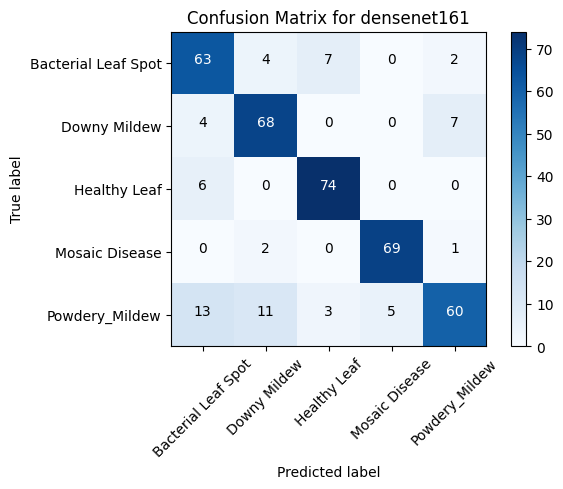

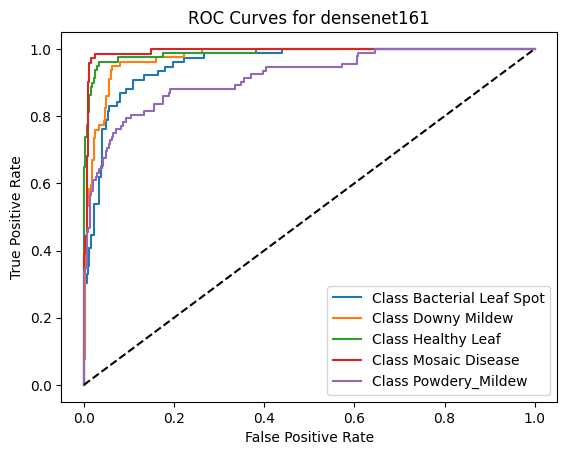


Evaluating model: inception_v3
Epoch 1/2


RuntimeError: Calculated padded input size per channel: (3 x 3). Kernel size: (5 x 5). Kernel size can't be greater than actual input size

In [72]:
# Loop through each pretrained model, train, and evaluate with optimal epochs
results = {}
for name, model in pretrained_models.items():
    print(f"\nEvaluating model: {name}")
    train_and_evaluate_model(model, name)

    # Collect and compare evaluation results for each model
    accuracy = evaluate_model_performance(model, dataloaders['val'], device)
    results[name] = accuracy

# Identify the best-performing model
best_model = max(results, key=results.get)
print(f"\nBest Performing Model: {best_model} with {results[best_model]:.2f}% Accuracy")